In [1]:
import cv2
import os
import sys
import shutil

from glob import glob
import matplotlib.pyplot as plt

In [15]:
label_dir = "./data/labels/"
video_path = "./data/original_movie/kamaitachi.mp4"

img_dir = "./data/tmp/"
save_dir = "./data/mosaic_images/"
ext = "jpg"
basename = "WIN_20210613_10_25_03_Pro"
output_dir = "./data/tmp/" + basename

os.makedirs(img_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [41]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def save_all_frames(video_path = video_path, dir_path=img_dir, ext = ext): 
    video_name = video_path.split("/")[-1].split(".")[0]
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, video_name)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    n = 1

    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n), ext), frame)
            n += 1
        else:
            return

def mosaic(src, ratio=0.1):
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    return cv2.resize(small, src.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

def mosaic_area(src, x, y, width, height, ratio=0.05):
    dst = src.copy()
    dst[y:y + height, x:x + width] = mosaic(dst[y:y + height, x:x + width], ratio)
    return dst

def yolo_mosaic_area(label_path, img_path):
    mosaic_img = cv2.imread(img_path)
    with open(label_path) as f:
        lines = f.readlines()
    
    for line in lines:
        line = line.split(" ")
        

        _, yolo_x, yolo_y, yolo_w, yolo_h = line
        yolo_h = yolo_h.replace('\n', '')
        img_height, img_with, _ = mosaic_img.shape

        x = float(yolo_x) * img_with
        y = float(yolo_y) * img_height
        w = float(yolo_w) * img_with
        h = float(yolo_h) * img_height
        cv_x = x - w/2
        cv_y = y - h/2

        mosaic_img = mosaic_area(mosaic_img, int(cv_x), int(cv_y), int(w), int(h))
    
    return mosaic_img


def yolo_mosaic_images(img_dir=img_dir, label_dir=label_dir, save_dir=save_dir):
    
    images = glob(img_dir + "*.jpg")

    for img_path in images:
        file_name = img_path.split("\\")[-1].split(".")[0]
        label_path = label_dir + file_name + ".txt"
        if os.path.exists(label_path):
            mosaic_img = yolo_mosaic_area(label_path, img_path)
            show_img(mosaic_img)
            cv2.imwrite(save_dir + file_name+".jpg", mosaic_img)

        else:
            img = cv2.imread(img_path)
            cv2.imwrite(save_dir + file_name+".jpg", img)
            #shutil.copyfile(img_path, save_dir + file_name + ".jpg")

def create_movie(mosaic_dir=save_dir, video_path = video_path, dir_path=img_dir, ext = ext):
    # encoder(for mp4)
    
    img_list = glob(mosaic_dir + "*.jpg")
    img1 = cv2.imread(img_list[0])
    h, w, _  = img1.shape
    print(w, h)
    
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    # output file name, encoder, fps, size(fit to image size)
    video = cv2.VideoWriter('video.mp4',fourcc, 28.0, (w, h))

    if not video.isOpened():
        print("can't be opened")
        sys.exit()
        
#     for i in range(len(img_list)):
#         img = cv2.imread(img_list[i])
#         video.write(img) 
    video_name = video_path.split("/")[-1].split(".")[0]
    base_path = os.path.join(mosaic_dir, video_name)

    n = 1

    while True:
        if os.path.exists('{}_{}.{}'.format(base_path, str(n), ext)):
            img = cv2.imread('{}_{}.{}'.format(base_path, str(n), ext))
            video.write(img) 
            n += 1
        else:
            video.release()
            return

        
    
    video.release()
    print('written')

1920 1040


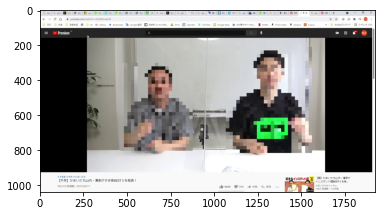

In [43]:
os.makedirs(img_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)
save_all_frames()
yolo_mosaic_images()
create_movie()
shutil.rmtree(img_dir)
shutil.rmtree(save_dir)